In [95]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [97]:
len(words)

32033

In [98]:
# build vocab of char and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [99]:
# build ds new
block_size = 3

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        #print w
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] 
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [100]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) * (5/3)/((n_embd*block_size)**.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * .01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0036) tensor(1.0047)
tensor(0.0006) tensor(1.0011)


(array([4.82785423e-05, 4.82785423e-05, 7.24178135e-05, 1.68974898e-04,
        1.68974898e-04, 4.82785423e-04, 8.44874491e-04, 1.23110283e-03,
        2.24495222e-03, 3.33121942e-03, 5.28650039e-03, 8.69013762e-03,
        1.28179530e-02, 1.91424420e-02, 2.80739724e-02, 4.10126217e-02,
        6.04688743e-02, 8.90739106e-02, 1.19175582e-01, 1.63567701e-01,
        2.15346438e-01, 2.67414846e-01, 3.29621748e-01, 3.68341139e-01,
        4.09595153e-01, 4.27192682e-01, 4.19299140e-01, 3.82993676e-01,
        3.39349874e-01, 2.86171060e-01, 2.29033405e-01, 1.76651186e-01,
        1.29458911e-01, 9.27672191e-02, 6.64312743e-02, 4.47300695e-02,
        3.07292922e-02, 2.04459627e-02, 1.33248777e-02, 8.27977001e-03,
        5.62445018e-03, 3.35535869e-03, 2.31737003e-03, 1.40007773e-03,
        1.08626720e-03, 3.13810525e-04, 3.37949796e-04, 1.93114169e-04,
        4.82785423e-05, 4.82785423e-05]),
 array([-5.30474472, -5.09761336, -4.89048201, -4.68335065, -4.47621929,
        -4.26908793, 

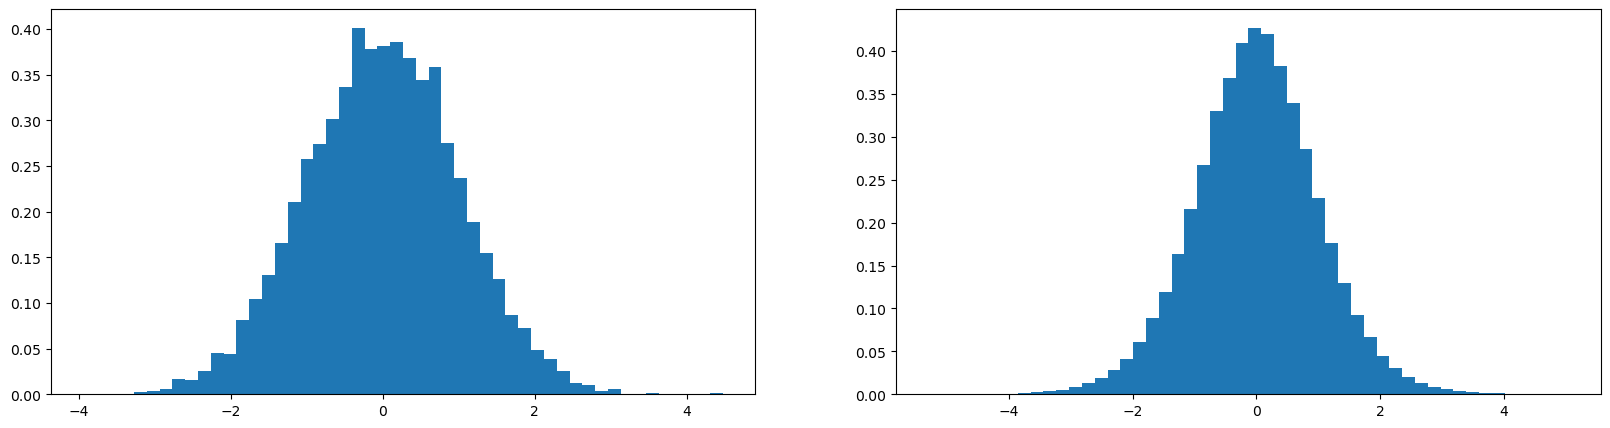

In [101]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [102]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [106]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #choose minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) /  bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 + bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 + bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3013
  10000/ 200000: 2.0035
  20000/ 200000: 2.0043
  30000/ 200000: 2.0937
  40000/ 200000: 2.2616
  50000/ 200000: 2.1408
  60000/ 200000: 2.0564
  70000/ 200000: 2.3588
  80000/ 200000: 2.3619
  90000/ 200000: 2.2137
 100000/ 200000: 2.3094
 110000/ 200000: 1.8927
 120000/ 200000: 2.2329
 130000/ 200000: 2.0224
 140000/ 200000: 1.7848
 150000/ 200000: 2.3820
 160000/ 200000: 2.2525
 170000/ 200000: 1.7767
 180000/ 200000: 1.9479
 190000/ 200000: 2.2804


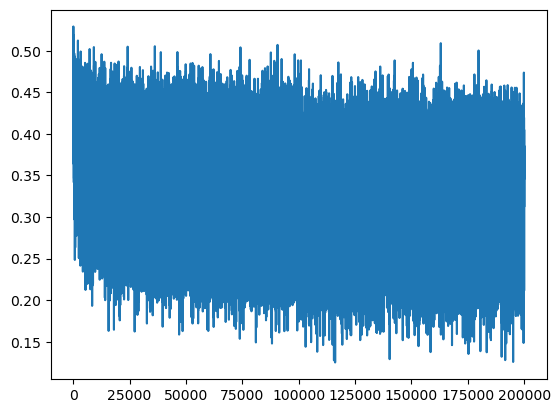

In [108]:
plt.plot(lossi)

In [109]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure mean/std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [110]:
bnmean

tensor([[-2.3635,  0.6516, -0.9296,  1.0131,  1.1148,  1.1065,  1.7500, -2.0866,
          0.5698,  1.4275, -1.5499, -2.7530, -0.4690, -0.1472, -0.1063, -1.1543,
          0.6656, -2.6034, -0.1506,  1.6345, -0.7456, -0.3437,  0.0470,  0.5823,
          1.1275,  0.3645,  2.0326,  0.5844,  0.8224,  1.7610, -0.3324, -0.8291,
         -0.0850, -0.5156, -0.3988, -1.1034, -0.1101,  0.3484, -0.4990,  0.9976,
         -0.3881, -1.3014, -0.2705, -0.2132,  0.7647,  0.7007,  2.0737, -0.7674,
          2.3829,  1.8815,  0.8523,  0.3098,  1.8865,  0.4628,  0.6292, -1.9025,
         -0.0333,  0.4174,  1.3721, -0.9021, -0.4495,  1.1715,  0.5747,  0.6060,
          1.5892,  1.1536, -1.0216,  2.1587, -0.6779,  0.0361, -0.1987, -0.4753,
          1.0020, -1.0565, -2.9942,  0.6890,  1.4534, -0.1633,  0.0985,  0.5329,
          0.2373,  1.2848,  2.0482,  0.6390,  0.0567, -0.0821, -1.6929,  0.2850,
          2.2502, -0.0412, -0.6559,  1.3990, -0.7817, -1.2099, -1.0455,  0.2252,
          0.1931, -0.3624,  

In [111]:
bnmean_running

tensor([[-2381.7114,   663.4859,  -915.9488,  1013.2762,  1118.1995,  1099.7924,
          1747.1198, -2099.8787,   557.7137,  1407.0436, -1559.5509, -2756.2568,
          -479.7011,  -156.6145,   -99.4074, -1136.9192,   670.3088, -2620.3826,
          -171.2685,  1626.0884,  -747.4895,  -322.2625,    46.2025,   582.9344,
          1129.3679,   365.8648,  2037.5718,   579.0071,   821.4774,  1766.9208,
          -342.9186,  -832.3282,   -82.0577,  -517.3491,  -400.1114, -1102.1641,
          -109.3012,   337.5453,  -494.6134,  1003.5934,  -395.1337, -1323.8179,
          -271.5294,  -208.7676,   768.5798,   710.5267,  2072.6787,  -781.5112,
          2378.7559,  1871.5153,   839.3883,   304.9386,  1877.4996,   463.7908,
           622.5020, -1903.9689,   -34.2271,   419.2205,  1389.8218,  -900.3580,
          -464.9986,  1165.5068,   569.0396,   602.3599,  1589.9160,  1138.5370,
         -1026.9972,  2153.9138,  -669.5683,    49.9804,  -204.7609,  -471.9937,
           990.1809, -1023.7

In [115]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.8019614219665527
val 3.8113465309143066


In [114]:
# sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

/var/folders/bm/w5ljn4r530zfg63nrr7c4kq40000gp/T/ipykernel_94064/647882742.py:14: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [122]:
# cleaned up

In [125]:
# training deeper network
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):

        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params - trained w backprop
        self.gamma = torch.ones(dim)
        self.bata = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calc forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize to unit vectors
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # dim of char embedding vectors
n_hidden = 100 # dim of neurosn in hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # num of param in total
for p in parameters:
    p.requires_grad = True

AttributeError: 'BatchNorm1d' object has no attribute 'beta'

In [126]:
# same optimization

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch constrcut
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss fn

    # backward pass
    for layer in layers:
        layer.out.retain_grad() 
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #trackstats 
    if i % 100 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])

    if i >= 1000:
        break

AttributeError: 'BatchNorm1d' object has no attribute 'beta'